In [1]:
import pandas as pd
import numpy as np
import eda
import visualization as viz
import feature_engineering as fe
import process_data as pr
import modeling as md

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

model_number = 'catboost_rfecv'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.sample(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
17297,17297,D,233.59,material_7,material_5,6,6,3,17,3,17.202,12.186,18.381,17.420,NaN,21.282,11.694,15.406,19.886,12.772,15.699,15.811,NaN,17.158,862.570,0
2012,2012,A,147.76,material_7,material_8,9,5,6,9,5,15.902,11.831,18.154,17.326,12.977,18.433,11.666,NaN,NaN,9.442,NaN,17.983,14.534,14.033,743.845,0
7670,7670,B,83.71,material_5,material_5,8,8,7,11,7,18.717,13.527,15.607,16.445,11.720,18.087,12.035,14.755,19.863,11.540,16.977,14.527,15.172,16.827,760.472,0


In [3]:
# Drop the id columns
dropped_columns = ['id', 'product_code']

df_train_model = df_train.drop(dropped_columns, axis=1)
df_test_model = df_test.drop(dropped_columns, axis=1)

# Assign train and test for X and y
X_train = df_train_model.drop('failure', axis=1)
y_train = df_train_model['failure']

X_test = df_test_model.copy()

In [4]:
X_train['m_3_missing'] = X_train.measurement_3.isna().astype(int)
X_train['m_5_missing'] = X_train.measurement_5.isna().astype(int)

X_test['m_3_missing'] = X_test.measurement_3.isna().astype(int)
X_test['m_5_missing'] = X_test.measurement_5.isna().astype(int)

In [5]:
cat_features = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'm_3_missing', 'm_5_missing']
continous_features = [cat for cat in X_train.columns if cat not in cat_features]
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns

In [6]:
si = SimpleImputer(strategy='mean')
# Apply preprocessing to the training data
X_train_transformed = si.fit_transform(X_train[continous_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train[continous_features].columns)
X_train = pd.concat([X_train[cat_features], X_train_transformed], axis=1)

X_test_transformed = si.transform(X_test[continous_features])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test[continous_features].columns)
X_test = pd.concat([X_test[cat_features], X_test_transformed], axis=1)

X_train.head()

,attribute_0,attribute_1,attribute_2,attribute_3,m_3_missing,m_5_missing,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,material_7,material_8,9,5,0,0,80.10,7.0,8.0,4.0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594000,15.193,15.029,16.048444,13.034,14.684,764.100
1,material_7,material_8,9,5,0,0,84.89,14.0,3.0,3.0,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915000,11.755,14.732,15.425000,14.395,15.631,682.057
2,material_7,material_8,9,5,0,0,82.43,12.0,1.0,5.0,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.172085,13.798,16.711,18.631000,14.094,17.946,663.376
3,material_7,material_8,9,5,0,0,101.07,13.0,2.0,6.0,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377000,10.020,15.250,15.562000,16.154,17.172,826.282
4,material_7,material_8,9,5,0,0,188.06,9.0,2.0,8.0,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932000,12.428,16.182,12.760000,13.153,16.412,579.885


In [7]:
target = 'failure'

combined_df = pd.concat([X_train, X_test])
combined_df.sample(2)

,attribute_0,attribute_1,attribute_2,attribute_3,m_3_missing,m_5_missing,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
18103,material_7,material_5,9,5,0,0,115.19,1.0,14.0,5.0,17.925,11.503,15.404,18.114,12.515000,19.024714,13.112,16.440,17.624,11.702464,17.374,19.688000,16.079,18.563,689.556
19292,material_7,material_5,6,6,0,0,172.74,9.0,13.0,6.0,17.683,10.794,17.117,16.594,11.716624,18.623000,12.005,17.977,19.171,12.640000,16.978,16.048444,14.622,17.150,602.836


In [21]:
X_train.shape

(26570, 25)

In [ ]:
# Define the proportion of the minority class you want to include in the subset
minority_proportion = 0.2  # Adjust as needed

# Split the dataset into training and testing subsets with stratified sampling
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X_train,  # Features
    y_train,  # Target variable
    test_size=1 - minority_proportion,  # Proportion of the majority class to include
    stratify=y_train,  # Use stratified sampling
    random_state=5  # Set a random seed for reproducibility
)

In [ ]:
X_train.shape, X_train_strat.shape, X_test_strat.shape

In [ ]:
print(eda.do_value_counts(pd.concat([X_train, y_train], axis=1), target))

In [ ]:
print(eda.do_value_counts(pd.concat([X_train_strat, y_train_strat], axis=1), target))

In [ ]:
print(eda.do_value_counts(pd.concat([X_test_strat, y_test_strat], axis=1), target))

Learning rate set to 0.067421
0:	learn: 0.6674029	test: 0.6677025	best: 0.6677025 (0)	total: 200ms	remaining: 3m 19s
100:	learn: 0.4932426	test: 0.5120779	best: 0.5116913 (43)	total: 5.44s	remaining: 48.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.511691277
bestIteration = 43

Shrink model to first 44 iterations.
Learning rate set to 0.067421
0:	learn: 0.6684629	test: 0.6685792	best: 0.6685792 (0)	total: 48.1ms	remaining: 48.1s
100:	learn: 0.4932890	test: 0.5104806	best: 0.5099546 (66)	total: 4.91s	remaining: 43.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5099546016
bestIteration = 66

Shrink model to first 67 iterations.
Learning rate set to 0.067421
0:	learn: 0.6684812	test: 0.6687370	best: 0.6687370 (0)	total: 54.6ms	remaining: 54.6s
100:	learn: 0.4937916	test: 0.5108562	best: 0.5105038 (89)	total: 5.68s	remaining: 50.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5105037637
bestIteration = 89

Shrink mo

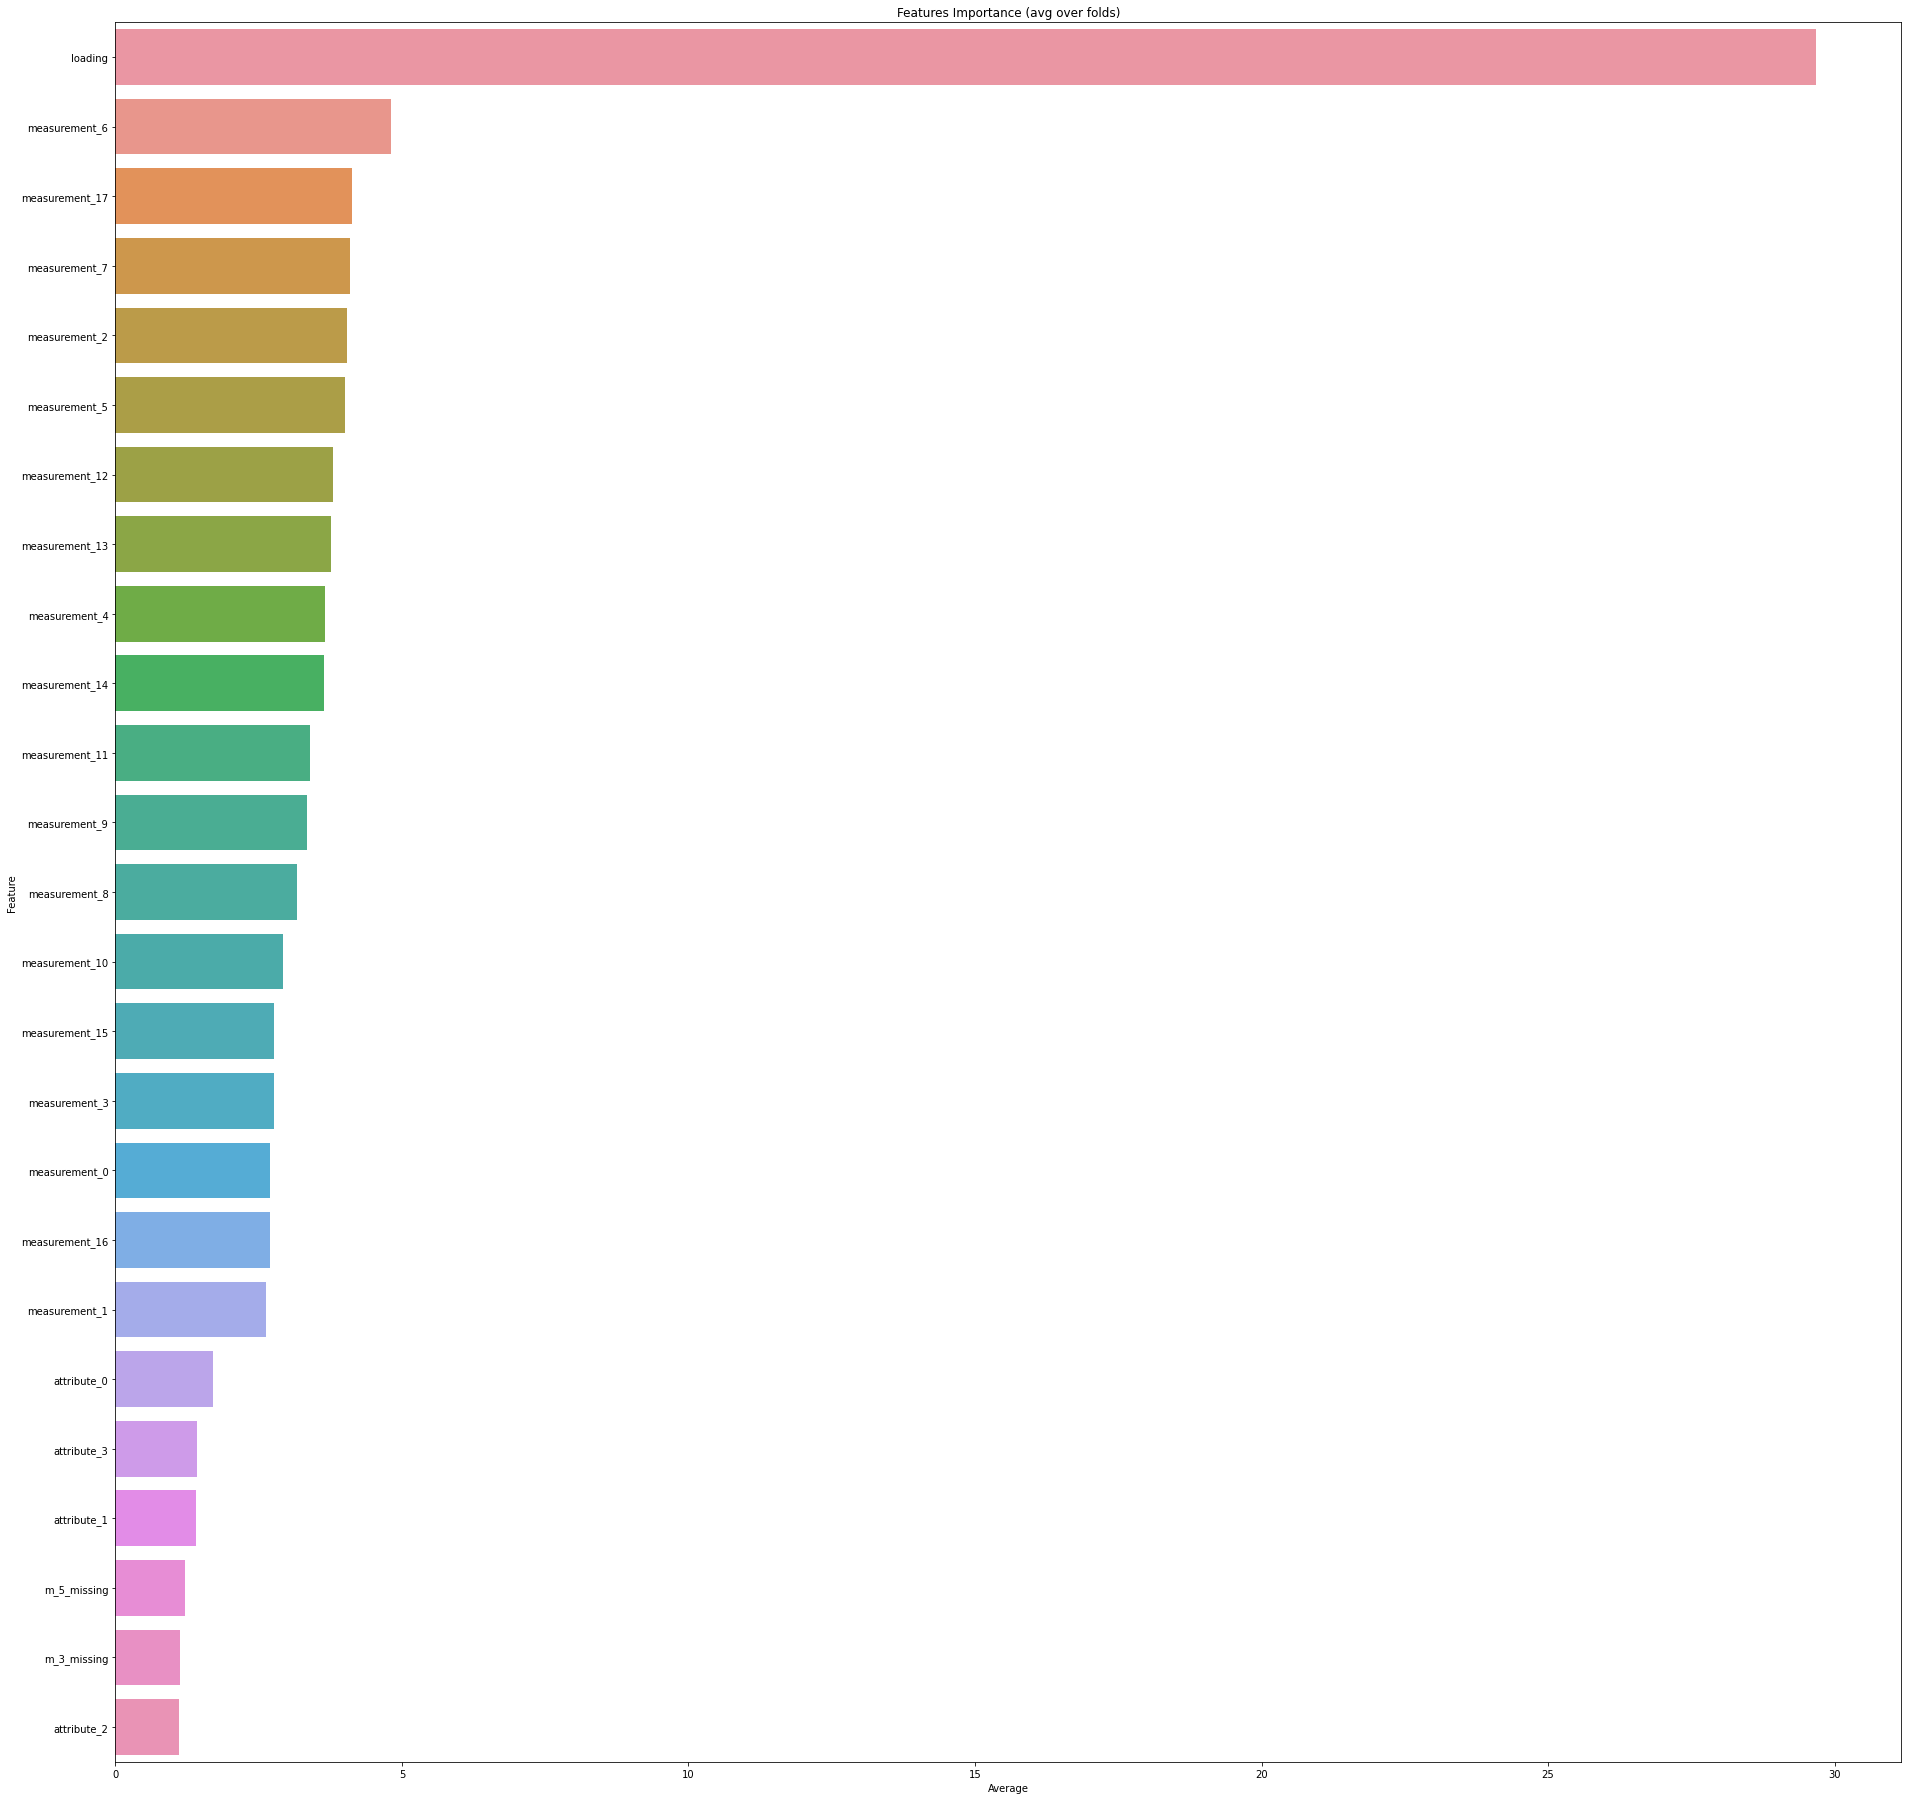

In [8]:
viz.plot_catboost_feature_importance(X_train, y_train, cat_features=cat_features, figsize=(32, 32))

In [9]:
# Create a blank DataFrame to store the results
result_df = pd.DataFrame({'Feature': X_train.columns})

# Calculate the mutual information scores 5 times
for i in range(5):
    mi_scores = fe.make_mi_scores_classification(X_train[numerical_features], y_train)
    result_df[f'Run_{i + 1}'] = mi_scores['MI Score']
    print(result_df.head(5))

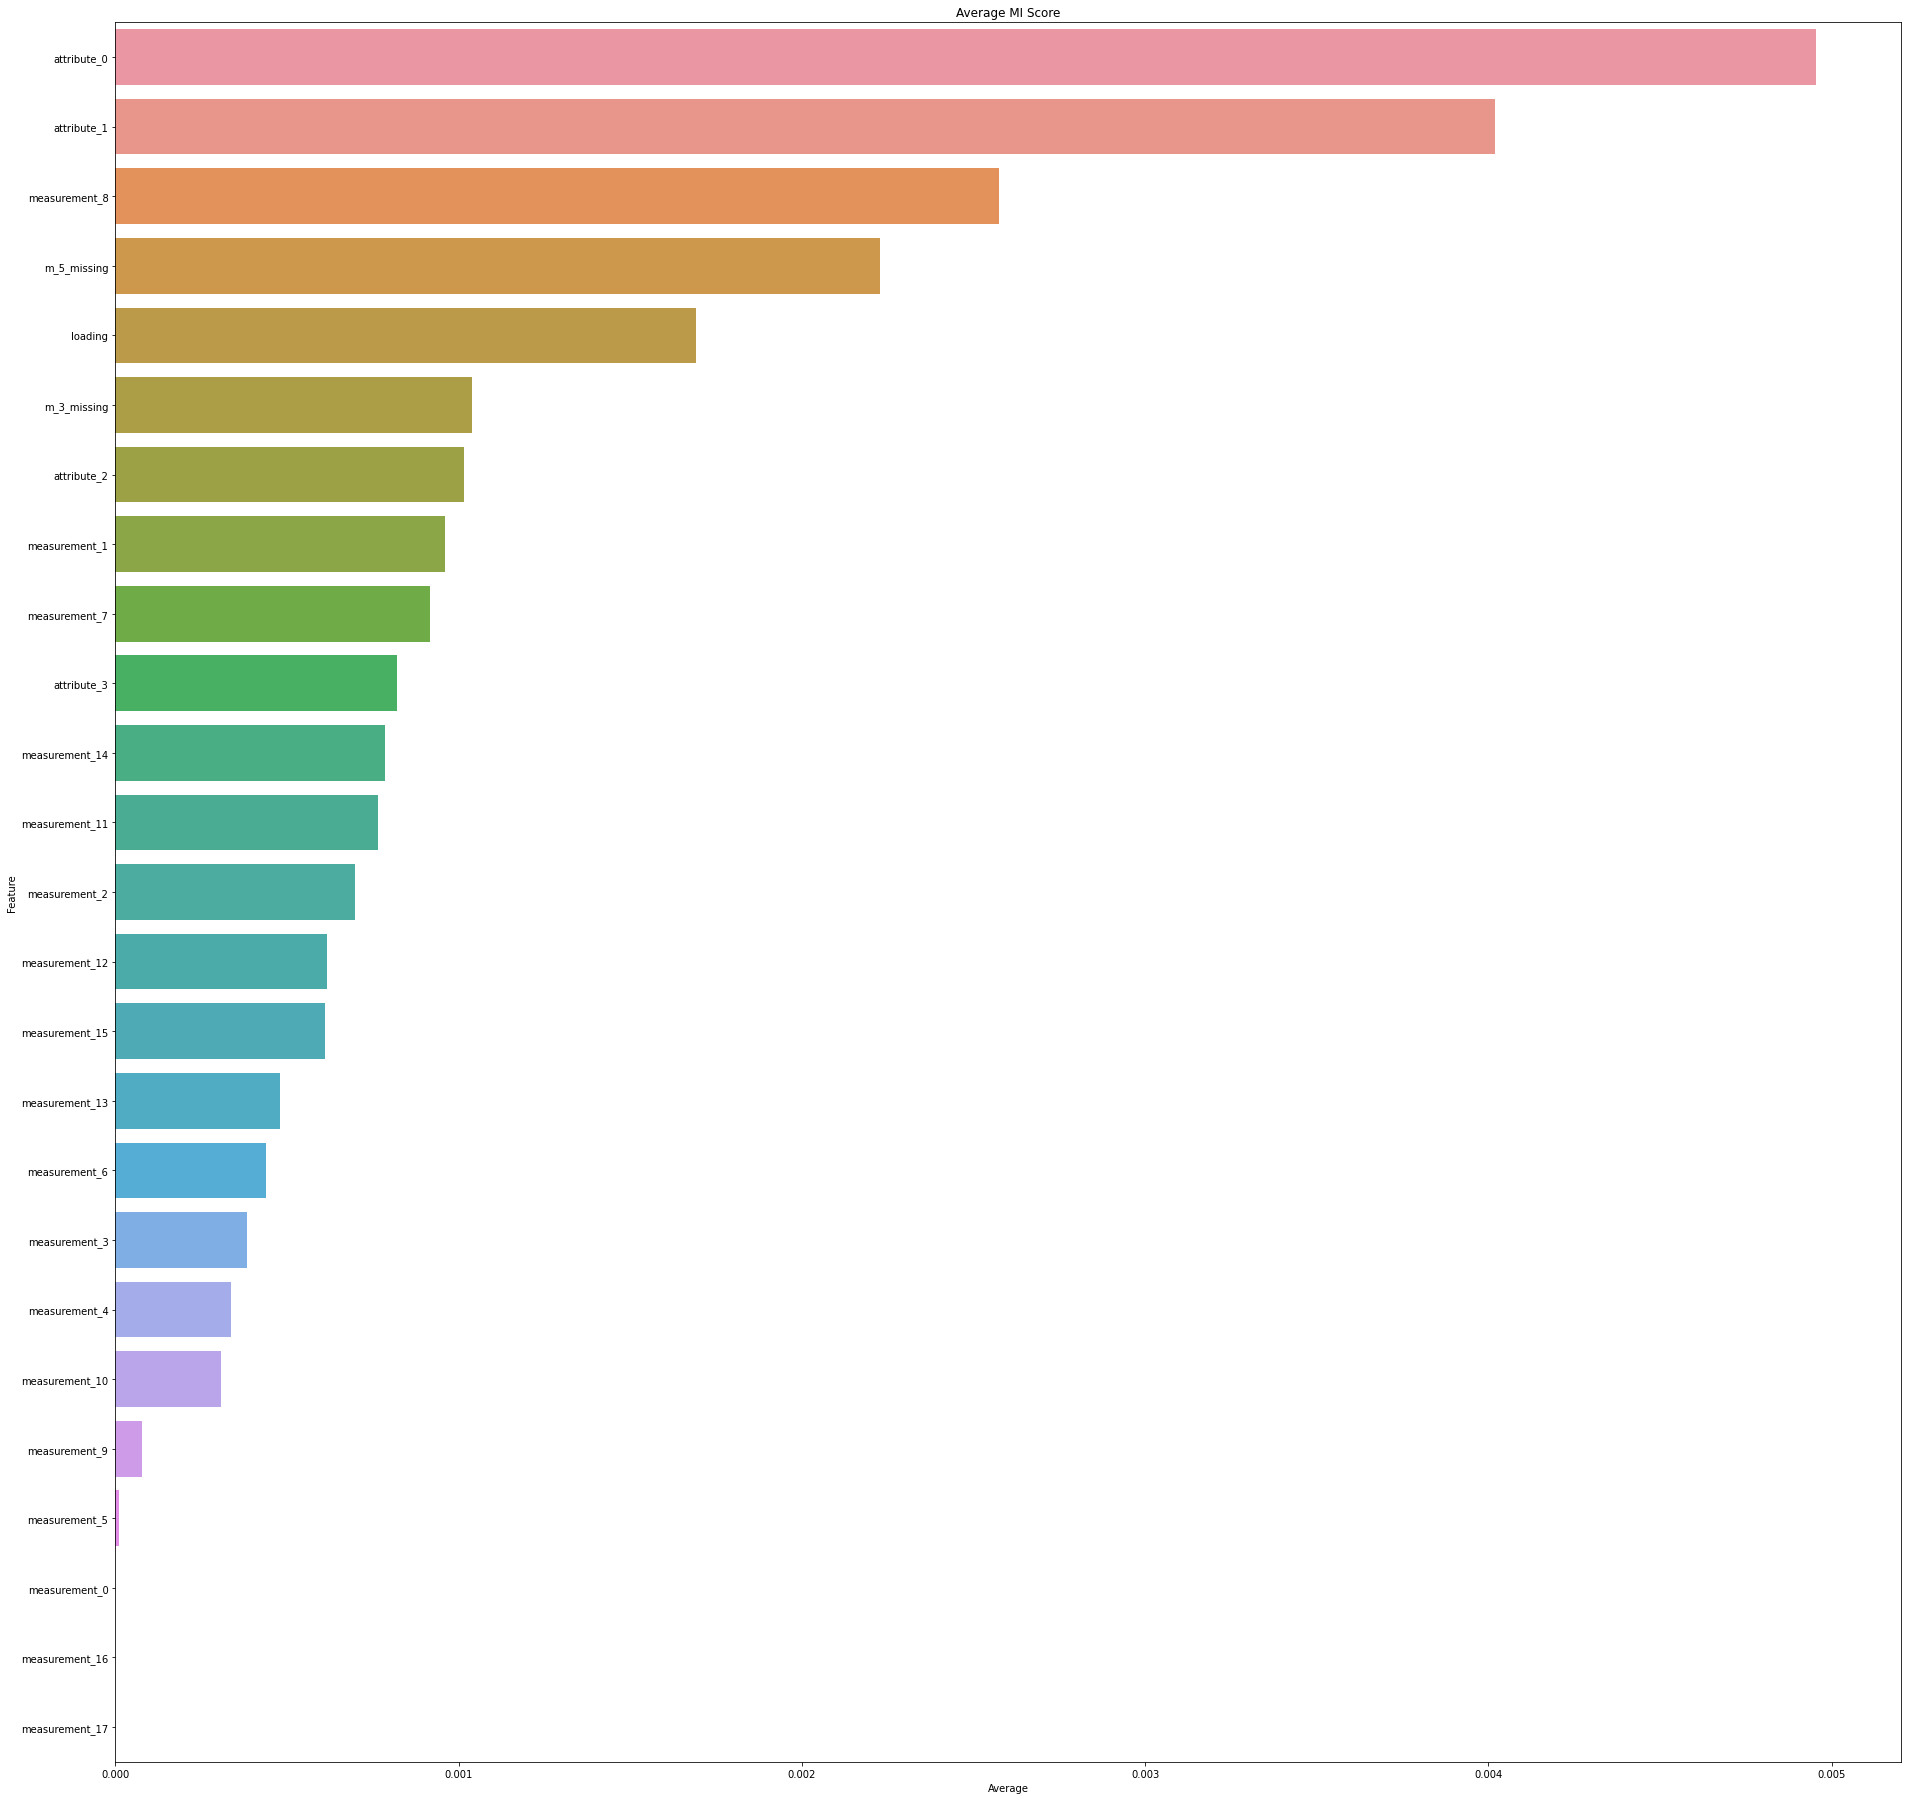

In [10]:
result_df['Average'] = result_df.iloc[:, 1:].mean(axis=1)
result_df = result_df.sort_values(by='Average', ascending=False)
result_df.to_csv(f'mi_result{model_number}.csv', index=False)

plt.figure(figsize=(32, 32))
sns.barplot(
    x=result_df['Average'],
    y=result_df['Feature'],
)

plt.title('Average MI Score')
plt.show()

In [11]:
fi_df = pd.read_csv('feature_importance.csv')

# Merge the DataFrames on col_a
merged_df = fi_df.merge(result_df, on='Feature')

# Print the merged DataFrame
merged_df = merged_df[['Feature', 'Average_x', 'Average_y']]

merged_df['FI_MI'] = merged_df.iloc[:, 1:].mean(axis=1, skipna=True, numeric_only=True)
merged_df = merged_df.sort_values(by='FI_MI', ascending=False)
merged_df

,Feature,Average_x,Average_y,FI_MI
6,loading,29.676887,0.001692,14.839290
24,measurement_17,4.128964,NaN,4.128964
23,measurement_16,2.689661,NaN,2.689661
13,measurement_6,4.809533,0.000439,2.404986
14,measurement_7,4.093958,0.000916,2.047437
9,measurement_2,4.040995,0.000697,2.020846
12,measurement_5,3.997422,0.000010,1.998716
19,measurement_12,3.797830,0.000618,1.899224
20,measurement_13,3.760696,0.000478,1.880587
11,measurement_4,3.657283,0.000336,1.828809


In [ ]:
# more_dropped_columns = ['attribute_2', 'measurement_2', 'measurement_7', 'measurement_12', 'measurement_16']
more_dropped_columns = []

# model_number = 'catboost_simpleimputer_domains'

In [12]:
feature_list = merged_df.iloc[:6, :]['Feature'].tolist()
feature_list

['loading',
 'measurement_17',
 'measurement_16',
 'measurement_6',
 'measurement_7',
 'measurement_2']

In [13]:
# Initialize CatBoost model
# model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1','attribute_2', 'attribute_3'], verbose=False)
model = CatBoostClassifier(random_state=5, verbose=False)

In [14]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=model, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

rfecv.fit(X_train[feature_list], y_train)
# rfecv.fit(X_train.drop(cat_features, axis=1), y_train)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFECV(cv=5,
      estimator=<catboost.core.CatBoostClassifier object at 0x000001DDAE550760>,
      n_jobs=-1, scoring='roc_auc', verbose=1)

In [15]:
# Get the RFECV ranking of all the features to select which ones to use
# Rank 1 are the features best suited for modelling but rank 2 features aren't bad
# And so on
rfecv_features = pd.DataFrame({'Feature': list(X_train[feature_list].columns),
                               'Ranking': rfecv.ranking_})

rfecv_features.sort_values(by='Ranking', inplace=True)

rfecv_features

,Feature,Ranking
0,loading,1
1,measurement_17,2
3,measurement_6,3
4,measurement_7,4
2,measurement_16,5
5,measurement_2,6


In [16]:
selected_features = [i for i, selected in enumerate(rfecv.support_) if selected]

In [17]:
selected_features

[0]

In [19]:
# Get a list of the rank 1 features
rfecv_rank_1 = list(X_train[feature_list].columns[selected_features])

rfecv_rank_1

['loading']

In [20]:
num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=5)

# scores = cross_val_score(model, X_train.drop(dropped_columns_low_fi, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
# scores = cross_val_score(model, X_train.drop(more_dropped_columns, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
scores = cross_val_score(model, X_train[rfecv_rank_1], y_train, cv=cv, n_jobs=-1, scoring='roc_auc')

list(scores), scores.mean(), scores.std()

([0.560684908457702,
  0.5843083216298075,
  0.5776412248938222,
  0.5724466573038461,
  0.5940398737711298],
 0.5778241972112614,
 0.011204451517786401)

In [ ]:
# Fit the model on the entire training data
# model.fit(X_train.drop(dropped_columns_low_fi, axis=1), y_train)
model.fit(X_train[rfecv_rank_1], y_train)

# Predict on the X_test data
# predictions = model.predict_proba(X_test.drop(dropped_columns_low_fi, axis=1))[:, 1]
predictions = model.predict_proba(X_test[rfecv_rank_1])[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame(
    {'id': df_test['id'],
    'failure': predictions})

# submission_df.head(50)
# Save to CSV for submission
submission_df.to_csv(f'submission_{model_number}.csv', index=False)